# **Thư viện**

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# **Dữ liệu**

In [46]:

df = pd.read_csv(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\data\processed\EUR_VND_Exchange_Rate.csv")
df["Date"] = pd.to_datetime(df["Date"])
timestamps = df["Date"].values   
df = df.set_index('Date')
df = df.select_dtypes(include=[np.number]).fillna(0).astype(np.float32)

lags = 30
for i in range(1, lags + 1):
    df[f'lag_{i}'] = df['Sell'].shift(i)
df.dropna(inplace=True)  
    
X = df.drop(columns=['Sell']).values
y = df['Sell'].values

df.head()

,Sell,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,26054.089844,26092.029297,...,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469,26506.550781,26506.550781
2020-05-02,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,26054.089844,...,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469,26506.550781
2020-05-03,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,26034.900391,...,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469,25936.230469
2020-05-04,26230.000000,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,26034.900391,...,26238.789062,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469,25936.230469
2020-05-05,26166.019531,26230.000000,26024.470703,26024.470703,26024.470703,26024.470703,26024.470703,25993.859375,26085.720703,26034.900391,...,26253.960938,26238.789062,26261.199219,26261.199219,26261.199219,26147.939453,26190.960938,26121.769531,26018.949219,25936.230469


# **Train/Test**

In [45]:
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
train_timestamps, test_timestamps = timestamps[:train_size], timestamps[train_size:]

# **Mô hình Random Forest**

In [4]:
def train_rf(X_train, y_train, model_path):
    """
    Huấn luyện Random Forest và lưu mô hình với tham số tối ưu
    """
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    joblib.dump(best_model, model_path)

    return best_model

def build_rf_model(best_hp):
    """
    Xây dựng mô hình Random Forest từ tham số tối ưu
    """
    model = RandomForestRegressor(
        n_estimators=best_hp.n_estimators,
        max_depth=best_hp.max_depth,
        min_samples_split=best_hp.min_samples_split,
        min_samples_leaf=best_hp.min_samples_leaf,
        random_state=42
    )
    return model


In [7]:
model_path = r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\RandomForest\best_rf_prices.pkl"
best_model = train_rf(X_train, y_train, model_path)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [8]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# **Đánh giá mô hình**

In [21]:
y_pred_test = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}{r2:.4f}\nMAPE: {mape:.4f} ({mape * 100:.2f}%)")


MAE: 70.5186
MSE: 9770.2998
RMSE: 98.84480.9617
MAPE: 0.0025 (0.25%)


# **Dự đoán và thực tế**

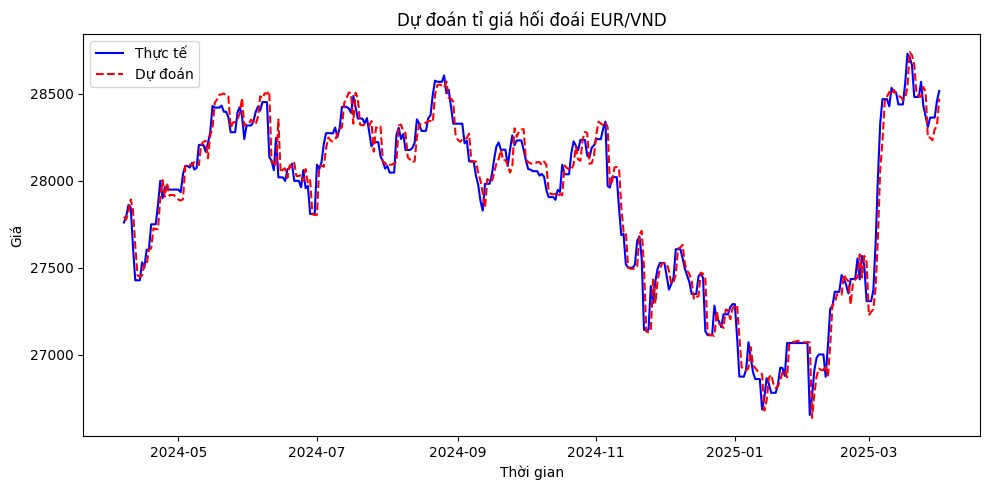

In [61]:
y_pred_test = best_model.predict(X_test)

# Tạo test_timestamps từ chỉ mục của dữ liệu kiểm tra (nếu không có thời gian sẵn)
test_timestamps = pd.to_datetime(test_timestamps)  # Đảm bảo timestamps là datetime

# Vẽ biểu đồ chỉ với dữ liệu kiểm tra (dự đoán và thực tế)
plt.figure(figsize=(10, 5))
plt.plot(test_timestamps, y_test, label="Thực tế", color="blue")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed", color="red")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỉ giá hối đoái EUR/VND")

# Chỉ hiển thị các năm trên trục x
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Hiển thị theo năm
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Định dạng chỉ hiển thị năm
# plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# **Dự đoán 30 ngày tiếp theo**


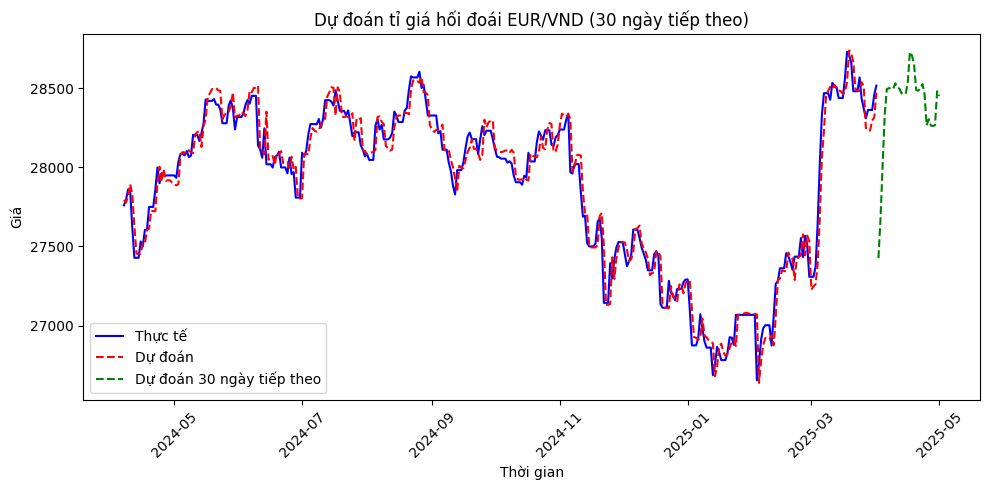

Dự đoán 30 ngày tiếp theo:
2025-04-02: 27426.9106
2025-04-03: 27680.1447
2025-04-04: 28017.1141
2025-04-05: 28335.7463
2025-04-06: 28495.4575
2025-04-07: 28500.9274
2025-04-08: 28497.7311
2025-04-09: 28494.4613
2025-04-10: 28531.3540
2025-04-11: 28503.1274
2025-04-12: 28497.5841
2025-04-13: 28468.2845
2025-04-14: 28464.8379
2025-04-15: 28464.2979
2025-04-16: 28539.6941
2025-04-17: 28729.0584
2025-04-18: 28706.5072
2025-04-19: 28649.4552
2025-04-20: 28488.8816
2025-04-21: 28485.2497
2025-04-22: 28497.8058
2025-04-23: 28526.7832
2025-04-24: 28461.7340
2025-04-25: 28266.3224
2025-04-26: 28304.4296
2025-04-27: 28264.3535
2025-04-28: 28260.6320
2025-04-29: 28267.6515
2025-04-30: 28481.1852
2025-05-01: 28451.7717


In [62]:
def predict_next_30_days(model, last_30_values, lags=30):
    # Tạo DataFrame với các giá trị cuối cùng (lag) để dự đoán các giá trị tiếp theo
    predictions = []
    current_input = last_30_values.copy()  # Copy giá trị cuối cùng vào input ban đầu
    
    for i in range(30):  # Dự đoán 30 ngày tiếp theo
        # Tạo các lag features từ dữ liệu hiện tại
        input_lags = np.array(current_input[-lags:]).reshape(1, -1)
        
        # Dự đoán giá trị tiếp theo
        next_value = model.predict(input_lags)[0]
        predictions.append(next_value)
        
        # Cập nhật input với giá trị dự đoán mới
        current_input = np.append(current_input, next_value)

    return predictions

# Lấy 30 giá trị cuối cùng trong dữ liệu huấn luyện
last_30_values = df['Sell'].values[-30:]

# Dự đoán 30 ngày tiếp theo
predictions_30_days = predict_next_30_days(best_model, last_30_values)

# Tạo mốc thời gian cho 30 ngày tiếp theo
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=31, freq='D')[1:]  # Bắt đầu từ ngày tiếp theo

# Vẽ biểu đồ với dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 5))
plt.plot(test_timestamps, y_test, label="Thực tế", color="blue")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed", color="red")
plt.plot(future_dates, predictions_30_days, label="Dự đoán 30 ngày tiếp theo", linestyle="dashed", color="green")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỉ giá hối đoái EUR/VND (30 ngày tiếp theo)")

# Định dạng trục x hiển thị theo ngày
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# In kết quả dự đoán 30 ngày tiếp theo
print("Dự đoán 30 ngày tiếp theo:")
for date, prediction in zip(future_dates, predictions_30_days):
    print(f"{date.strftime('%Y-%m-%d')}: {prediction:.4f}")
